# Aim

This recipe shows how to:
- Load a month of AUS2200 data (entire spatial domain) with xarray (dask-enabled) and chunk the data for efficient computing
- Calculate air temperature perturbations to the daily mean (using xarray rolling mean)

## First load some python modules

Requires access to the hh5 conda environment

In [1]:
import pandas as pd
import xarray as xr
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask.array as da
import dask
from dask.distributed import Client
from dask import delayed

## Dask-optimiser
Note that we loaded [dask-optimiser](https://coecms.github.io/posts/2023-09-20-dask-optimiser.html?highlight=dask+optimiser) into our ARE session. You can load this by modifying your ARE setup under "modules" (conda/analysis3 dask-optimiser). This module ensures that dask is optimally set up for working on Gadi 

## Compute size
We are working with XX-Large resources on ARE (28 cores, 126 GB)

In [2]:
#Set up a dask distributed client, so that chunks of data can be sent and 
# processed by different cores/"workers".

# Click "Launch dashboard in JupyterLab" within this cell's output to see dask progress

client = Client()
client

2024-12-05 21:15:01,259 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-12-05 21:15:01,264 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-12-05 21:15:01,290 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-hmem-bdw-0003.gadi.nci.org.au/26997/proxy/8787/status,
Dashboard: /node/gadi-hmem-bdw-0003.gadi.nci.org.au/26997/proxy/8787/status,Workers: 21
Total threads: 21,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42321,Workers: 21
Dashboard: /node/gadi-hmem-bdw-0003.gadi.nci.org.au/26997/proxy/8787/status,Total threads: 21
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:42101,Total threads: 1
Dashboard: /node/gadi-hmem-bdw-0003.gadi.nci.org.au/26997/proxy/44945/status,Memory: 0 B
Nanny: tcp://127.0.0.1:46475,


## Load in the AUS2200 data

Using load_aus2200_variable(). Requires access to the ua8 project on Gadi

In [3]:
def load_aus2200_variable(vnames, t1, t2, exp_id, lon_slice, lat_slice, freq, hgt_slice=None, chunks="auto"):

    '''
    Load variables from the mjo-enso AUS2200 experiment, stored on the ua8 project

    ## Input

    * vnames: list of names of aus2200 variables

    * t1: start time in %Y-%m-%d %H:%M"

    * t2: start time in %Y-%m-%d %H:%M"
    
    * exp_id: string describing the experiment. either 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'

    * lat_slice: a slice to restrict lat domain

    * lon_slice: a slice to restrict lon domain

    * freq: time frequency (string). either "10min", "1hr", "1hrPlev"

    * hgt_slice: a slice to restrict data in the vertical (in m)

    * chunks: dict describing the number of chunks. see xr.open_dataset
    '''

    #This code makes sure the inputs for experiment id and time frequency match what is on disk 
    assert exp_id in ['mjo-elnino', 'mjo-lanina', 'mjo-neutral'], "exp_id must either be 'mjo-elnino', 'mjo-lanina' or 'mjo-neutral'"
    assert freq in ["10min", "1hr", "1hrPlev"], "exp_id must either be '10min', '1hr', '1hrPlev'"

    #We are loading a list of files from disk using xr.open_mfdataset. This preprocessing 
    # just slices the lats, lons and levels we are interested in for each file, which is more efficient
    def _preprocess(ds):
        ds = ds.sel(lat=lat_slice,lon=lon_slice)
        return ds
    def _preprocess_hgt(ds):
            ds = ds.sel(lat=lat_slice,lon=lon_slice,lev=hgt_slice)
            return ds    
    
    out = []
    for vname in vnames:
        fnames = "/g/data/ua8/AUS2200/"+exp_id+"/v1-0/"+freq+"/"+vname+"/"+vname+"_AUS2200_"+exp_id+"_*.nc"
        if hgt_slice is not None:
            ds = xr.open_mfdataset(fnames, 
                                   chunks=chunks, 
                                   parallel=True, 
                                   preprocess=_preprocess_hgt, 
                                   engine="h5netcdf").sel(time=slice(t1,t2))
        else:
            ds = xr.open_mfdataset(fnames,
                                   chunks=chunks,
                                   parallel=True,
                                   preprocess=_preprocess,
                                   engine="h5netcdf").sel(time=slice(t1,t2))
        out.append(ds[vname])
        
    return out

#Define lat lon slices, equivalent to almost the entire AUS2200 domain
lon_slice = slice(108,159)
lat_slice = slice(-45.7,-6.831799)    

#Define times to slice
t1="2016-01-01 00:00"
t2="2016-02-01 00:00"

#Load air temperature for a single model level (111.7 m)
aus2200_ta = load_aus2200_variable(["ta"],
                                   t1,t2,
                                   "mjo-elnino",
                                   lon_slice,lat_slice,
                                   "1hr",
                                   hgt_slice=slice(100,120),
                                   chunks=({"time":6,"lat":-1,"lon":-1}) 
                                  )[0]


In [4]:
aus2200_ta

<xarray.DataArray 'ta' (time: 744, lev: 1, lat: 1963, lon: 2575)> Size: 15GB
dask.array<getitem, shape=(744, 1, 1963, 2575), dtype=float32, chunksize=(6, 1, 1963, 2575), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-02-01
  * lev      (lev) float64 8B 111.7
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.891 -6.871 -6.852
  * lon      (lon) float64 21kB 108.0 108.0 108.1 108.1 ... 158.9 159.0 159.0
Attributes:
    standard_name:          air_temperature
    long_name:              Air Temperature
    comment:                Air Temperature
    units:                  K
    cell_methods:           area: mean time: point
    cell_measures:          area: areacella
    history:                2023-10-21T14:23:16Z altered by CMOR: replaced mi...
    coverage_content_type:  modelResult

## Chunks

Note that we specified the chunks as {"time":6,"lat":-1,"lon":-1,"lev":{}}. For lat and lon, "-1" means that the chunk sizes in those dimensions (1963 for lat, 2574 for lon) are equivalent to the length of the dimensions. In other words, the dataset is not chunked up in those dimensions. 

However, the dataset is chunked along time (with a chunk size of 6). This is the best we can do for AUS2200 as each file is 6 time steps long. We can rechunk the time dimension later by calling aus2200_ta.chunk({"time":chunksize}), but this can be very slow.

Our aim is to have small enough chunks to fit on memory, but large enough chunks to reduce the time taken to pass data between workers and to reduce the number of operations dask is doing. The chunk size here (115 MB) is okay, with around 200 MB being a pretty good aim (although there is no standard rules around what chunk sizes are optimal, it takes some experimenting)

## Rolling daily mean

Now we'd like to compute a rolling daily average temperature. Rolling operations can be very slow, because for each point we need to access neighbouring time chunks 

In [5]:
time_window = 24      #equivalent to one day for the hourly data here
min_periods = 12      #for each time step, there must be at least 12 hours in the moving window
                      # for the rolling mean to be defined.
aus2200_ta_daily_mean = aus2200_ta.\
            rolling(dim={"time":24},center=True,min_periods=12).\
            mean()

In [6]:
aus2200_ta_daily_mean

<xarray.DataArray 'ta' (time: 744, lev: 1, lat: 1963, lon: 2575)> Size: 15GB
dask.array<truediv, shape=(744, 1, 1963, 2575), dtype=float32, chunksize=(24, 1, 1963, 2575), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-02-01
  * lev      (lev) float64 8B 111.7
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.891 -6.871 -6.852
  * lon      (lon) float64 21kB 108.0 108.0 108.1 108.1 ... 158.9 159.0 159.0
Attributes:
    standard_name:          air_temperature
    long_name:              Air Temperature
    comment:                Air Temperature
    units:                  K
    cell_methods:           area: mean time: point
    cell_measures:          area: areacella
    history:                2023-10-21T14:23:16Z altered by CMOR: replaced mi...
    coverage_content_type:  modelResult

## Computing

Note that dask hasn't done anything yet because we haven't actually needed to access any data (with only metadata shown above so far). When we start making plots in the following cells, then dask will actually start doing computations and loading the required data into memory.

If for some reason we would like all the data in memory to access it, we can use compute() or perstist() commands, such as 

`aus2200_ta_daily_mean = aus2200_ta_daily_mean.persist()`

## Plotting

Lets plot a single time step and start some computations. Note that the daily mean here smooths out small variations compared with the original temperature field

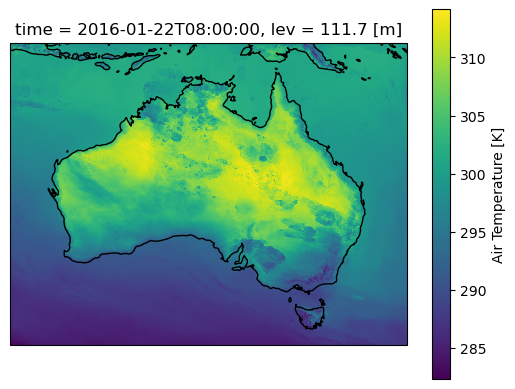

In [7]:
#First for the original air temperature data
ax=plt.axes(projection=ccrs.PlateCarree())
aus2200_ta.sel(time="2016-01-22 08:00").plot()
ax.coastlines()

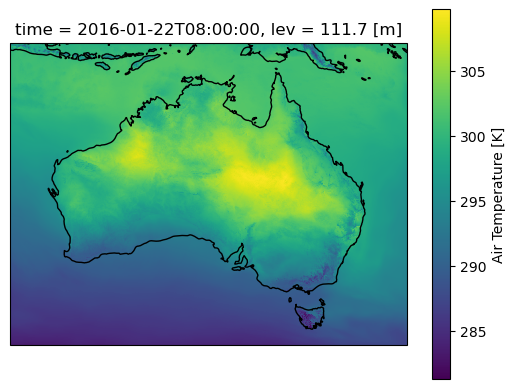

In [8]:
#And for the rolling daily mean
ax=plt.axes(projection=ccrs.PlateCarree())
aus2200_ta_daily_mean.sel(time="2016-01-22 08:00").plot()
ax.coastlines()

## Perturbations

Now calculate the temperature perturbations relative to the daily mean. Perturbations will re-introduce and highlight small-scale factors like convective cold pools and sea breezes along the coast, as well as allowing us to quantify the diurnal cycle.

In [9]:
aus2200_ta_daily_pert = aus2200_ta - aus2200_ta_daily_mean

In [10]:
aus2200_ta_daily_pert

<xarray.DataArray 'ta' (time: 744, lev: 1, lat: 1963, lon: 2575)> Size: 15GB
dask.array<sub, shape=(744, 1, 1963, 2575), dtype=float32, chunksize=(6, 1, 1963, 2575), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 2016-01-01T01:00:00 ... 2016-02-01
  * lev      (lev) float64 8B 111.7
  * lat      (lat) float64 16kB -45.7 -45.68 -45.66 ... -6.891 -6.871 -6.852
  * lon      (lon) float64 21kB 108.0 108.0 108.1 108.1 ... 158.9 159.0 159.0

## Plotting

As above, but for temperatue perturbations. Also plot for a single lat/lon location for the entire month

Note that the time series computation takes a lot longer, because dask needs to access many more files on disk (AUS2200 data is saved in 6-hourly files as discussed earlier)

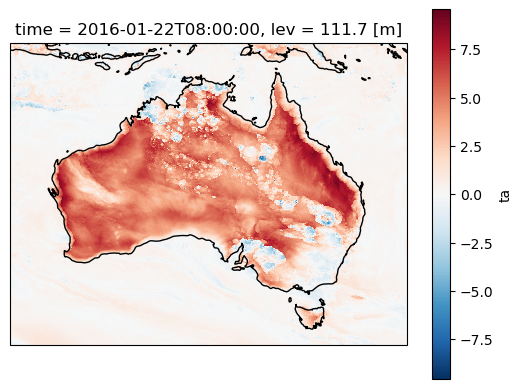

In [11]:
ax=plt.axes(projection=ccrs.PlateCarree())
aus2200_ta_daily_pert.sel(time="2016-01-22 08:00").plot()
ax.coastlines()

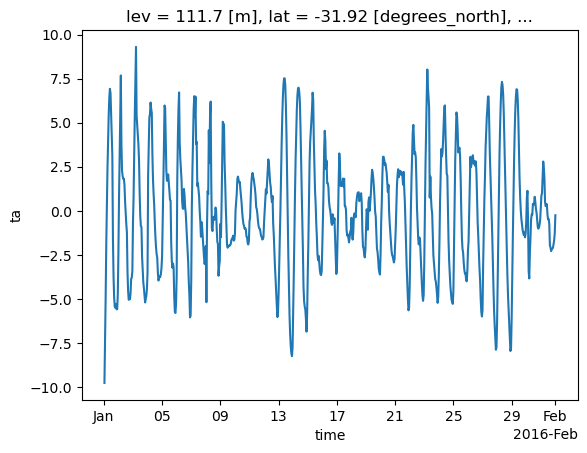

In [12]:
aus2200_ta_daily_pert.sel(lat=-31.9275, lon=115.9764, method="nearest").plot()

#### Authors

* **Andrew Brown**

    ARC Centre of Excellence for 21st Century Weather, University of Melbourne
    
    a.brown1@unimelb.edu.au

* **Samuel Green**

    ARC Centre of Excellence for 21st Century Weather & Climate Change Research Centre, UNSW Sydney
    
    sam.green@unsw.edu.au